In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/fake-news-football/real.csv
/kaggle/input/fake-news-football/fake.csv
/kaggle/input/huggingface-bert-variants/bert-large-uncased/bert-large-uncased/config.json
/kaggle/input/huggingface-bert-variants/bert-large-uncased/bert-large-uncased/tokenizer.json
/kaggle/input/huggingface-bert-variants/bert-large-uncased/bert-large-uncased/tf_model.h5
/kaggle/input/huggingface-bert-variants/bert-large-uncased/bert-large-uncased/tokenizer_config.json
/kaggle/input/huggingface-bert-variants/bert-large-uncased/bert-large-uncased/pytorch_model.bin
/kaggle/input/huggingface-bert-variants/bert-large-uncased/bert-large-uncased/vocab.txt
/kaggle/input/huggingface-bert-variants/bert-large-uncased/bert-large-uncased/flax_model.msgpack
/kaggle/input/huggingface-bert-variants/bert-large-uncased/bert-large-uncased/whole-word-masking/._bert_config.json
/kaggle/input/huggingface-bert-variants/bert-large-uncased/bert-large-uncased/whole-word-masking/bert_config.json
/kaggle/input/huggingface-bert-v

In [2]:
import warnings
warnings.simplefilter("ignore")
#general purpose packages
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

#data processing
import re, string
from wordcloud import WordCloud
from collections import Counter
import emoji
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

#keras
import tensorflow as tf
from tensorflow import keras


#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

#set seed for reproducibility
seed=42

In [3]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

 # <h1 style='background:#0000FF; border:0; color:white'><center>FAKE NEWS CLASSIFICATION</center></h1> 

 # **<span style="color:#0000FF;">Loading Data</span>**

In [4]:
df_real=pd.read_csv('/kaggle/input/fake-news-football/real.csv')
df_fake=pd.read_csv('/kaggle/input/fake-news-football/fake.csv')

In [5]:
df_real['label']=0
df_fake['label']=1
df=pd.concat([df_real,df_fake],ignore_index=True)

In [6]:
df['label'].value_counts()

0    21869
1    19999
Name: label, dtype: int64

 # **<span style="color:#0000FF;">Tweets Deep Cleaning</span>** 

In [7]:
##CUSTOM DEFINED FUNCTIONS TO CLEAN THE TWEETS

#Clean emojis from text
def strip_emoji(text):
    return emoji.demojize(text, language='en') #remove emoji
    
#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(@|https?\:\/\/)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

In [8]:
df['tweet']=df['tweet'].astype('str')

In [9]:
df['tweet'] = df['tweet'].apply(lambda t : remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

# ****
 # <h1 style='background:#0000FF; border:0; color:white'><center>EDA & Visualization</center></h1> 


 # **<span style="color:#0000FF;">Kdeplot by Total Words</span>** 

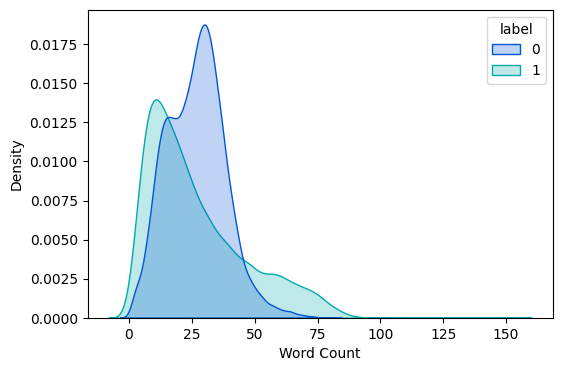

In [10]:
plt.figure(figsize = (6, 4))
sns.kdeplot(x = df['tweet'].apply(lambda x:len(x.split())), hue= df['label'], palette= 'winter', fill = True)
plt.xlabel('Word Count')
plt.show()

### WordCloud

In [11]:
def wordcloud_text(text):
    plt.figure(figsize = (10, 8))
    wordcloud = WordCloud(max_words=500, height= 800, width = 1500,  background_color="black", colormap= 'viridis').generate(text)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

In [12]:
real_text = " ".join(df[df['label'] == 0]['tweet'])
fake_text = " ".join(df[df['label'] == 0]['tweet'])

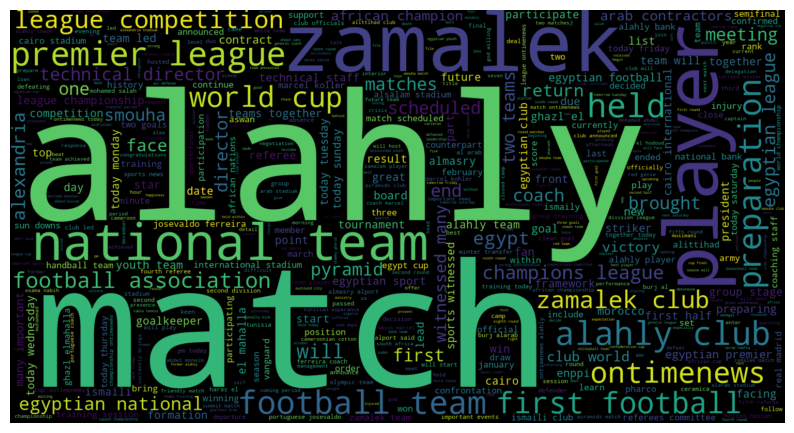

In [13]:
wordcloud_text(real_text)

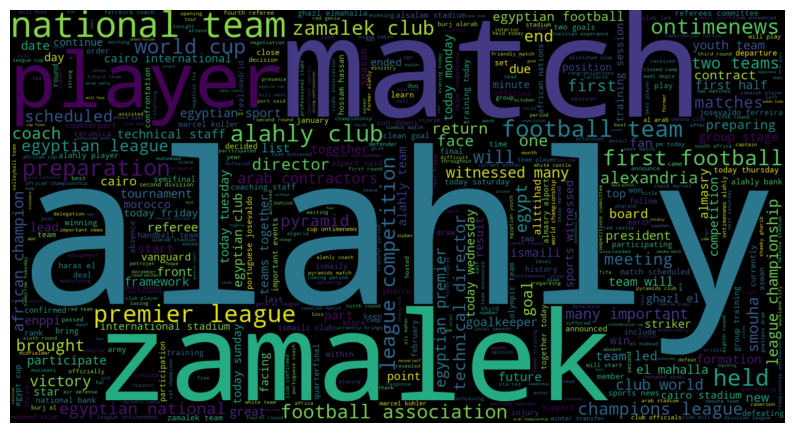

In [14]:
wordcloud_text(fake_text)

In [15]:
df['tweet_len'] = df['tweet'].apply(lambda x: len(x.split()))

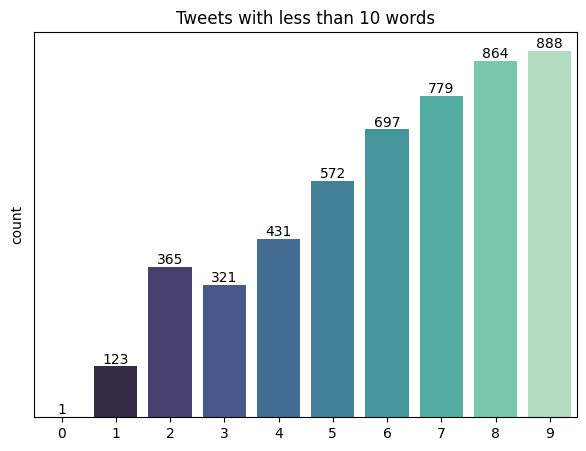

In [16]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='tweet_len', data=df[df['tweet_len']<10], palette='mako')
plt.title('Tweets with less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

**We will drop these empty tweets and also those with less than 5 words.**

In [17]:
df = df[df['tweet_len'] > 4]

In [18]:
df[df['tweet_len']>100]

,tweet,label,tweet_len
24774,yesterday i decided to go and play football wi...,1,103
34592,crown prince alahly destroys 1 ha ha ha ha ha ...,1,152
35017,a boy met me on the street you hadnt seen him ...,1,102


In [19]:
df_texts, df_labels = df["tweet"].to_list(),df["label"].to_list()

 # **<span style="color:#0000FF;">Splitting train dataset into training and validation dataset</span>** 

In [20]:
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels, val_labels = train_test_split(df_texts, df_labels, test_size=.2)


 # **<span style="color:#0000FF;">Using the DistilBert tokenizer</span>**  

In [21]:
from transformers import BertTokenizer, TFBertModel,BertForSequenceClassification,DistilBertTokenizerFast

In [22]:
#model_name = '/kaggle/input/huggingface-bert-variants/bert-base-cased/bert-base-cased'
model_name = '/kaggle/input/huggingface-bert-variants/distilbert-base-uncased/distilbert-base-uncased'
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

In [23]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


 # **<span style="color:#0000FF;">Dataset object function</span>**  

**PyTorch Dataset is a crucial step in preparing your data for training a model. It allows you to organize your data in a format that can be easily utilized by PyTorch's DataLoader/Trainer, which efficiently handles batching, shuffling, and parallel data loading during training.**

In [24]:
import torch

class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)

 # **<span style="color:#0000FF;">Defining the Metrics for evaluation</span>**  

In [25]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

 # **<span style="color:#0000FF;">Fine-tuning with Huggingface Trainer</span>**  

In [26]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments
import os
os.environ["WANDB_DISABLED"] = "true"

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

model = DistilBertForSequenceClassification.from_pretrained(model_name)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,             # evaluation dataset
)

trainer.train()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Some weights of the model checkpoint at /kaggle/input/huggingface-bert-variants/distilbert-base-uncased/distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassificati

Step,Training Loss
10,0.684800
20,0.691000
30,0.671000
40,0.661200
50,0.616100
60,0.562800
70,0.474700
80,0.403100
90,0.307100
100,0.281100


TrainOutput(global_step=3048, training_loss=0.08326033875101742, metrics={'train_runtime': 724.4971, 'train_samples_per_second': 134.58, 'train_steps_per_second': 4.207, 'total_flos': 3329898198813648.0, 'train_loss': 0.08326033875101742, 'epoch': 3.0})

In [27]:
trainer.evaluate()

{'eval_loss': 0.1289118230342865,
 'eval_accuracy': 0.9705882352941176,
 'eval_f1': 0.9674785685127227,
 'eval_precision': 0.9796087076329567,
 'eval_recall': 0.9556451612903226,
 'eval_runtime': 22.4663,
 'eval_samples_per_second': 361.697,
 'eval_steps_per_second': 2.849,
 'epoch': 3.0}

**<span style="color:#003f5c;"> If you liked this Notebook, please do upvote.</span>**

**<span style="color:#003f5c;"> If you have any suggestions or questions, I am all ears!</span>**

**<span style="color:#003f5c;">Best Wishes!</span>**

<a id="5"></a> 
# <h1 style='background:#003f5c; border:0; color:white'><center>END</center></h1> 